In [2]:
import pandas as pd
import numpy as np

from sklearn.ensemble import IsolationForest
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings(action = 'ignore')

# Load train and validation dataset

In [4]:
train_df = pd.read_csv('dataset/train.csv')
train_df.head()

,ID,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30
0,3,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,4.983721,-0.994972
1,4,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,1.418291,-0.994972
2,6,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,-0.256131,-0.994960
3,8,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,0.262698,-0.994901
4,9,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,0.994900,-0.994901


In [5]:
val_df = pd.read_csv("dataset/val.csv")
val_df.head()

,ID,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,V29,V30,Class
0,10,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,-0.255991,-0.994878,0
1,22,0.962496,0.328461,-0.171479,2.109204,1.129566,1.696038,0.107712,0.521502,-1.191311,...,0.402492,-0.048508,-1.371866,0.390814,0.199964,0.016371,-0.014605,0.168937,-0.994784,0
2,63,1.145524,0.575068,0.194008,2.598192,-0.092210,-1.044430,0.531588,-0.241888,-0.896287,...,-0.119703,-0.076510,0.691320,0.633984,0.048741,-0.053192,0.016251,0.169496,-0.994502,0
3,69,0.927060,-0.323684,0.387585,0.544474,0.246787,1.650358,-0.427576,0.615371,0.226278,...,0.079359,0.096632,-0.992569,0.085096,0.377447,0.036096,-0.005960,0.331307,-0.994467,0
4,83,-3.005237,2.600138,1.483691,-2.418473,0.306326,-0.824575,2.065426,-1.829347,4.009259,...,-0.181268,-0.163747,0.515821,0.136318,0.460054,-0.251259,-1.105751,-0.287012,-0.994373,0


# Check Train/Validation Feature distribution

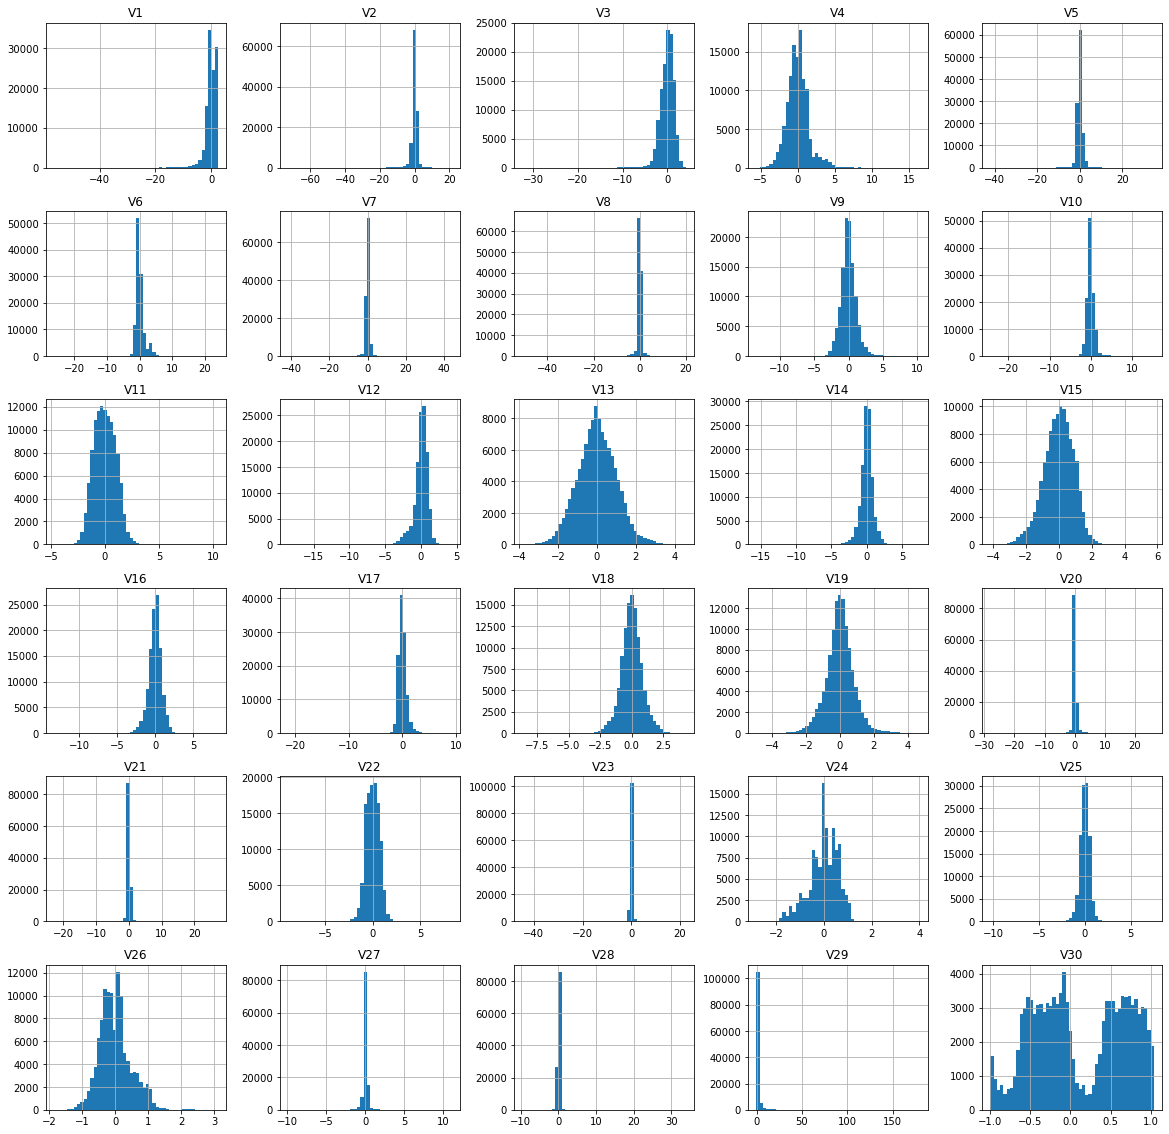

In [7]:
train_df.drop(columns=['ID']).hist(bins= 50, figsize =(20,20))
plt.show()

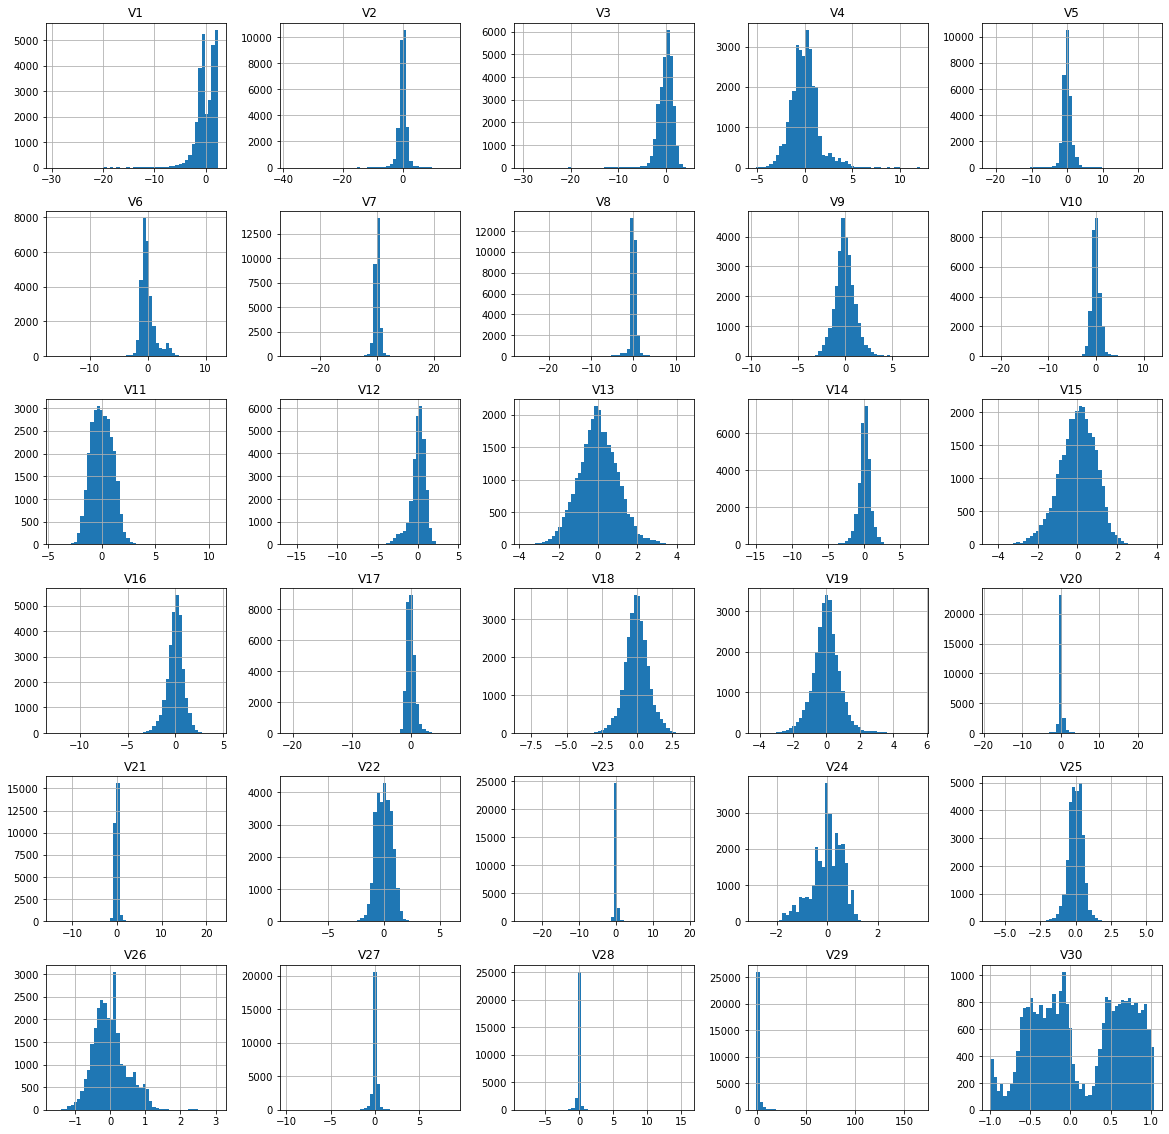

In [8]:
val_df.drop(columns=['ID','Class']).hist(bins = 50, figsize=(20,20))
plt.show()

# Fraud trade rate in Validation set
Assumption : The validation set will have the same fraud rate as the training set


In [13]:
val_normal, val_fraud = val_df['Class'].value_counts()
val_contamination = val_fraud / val_normal
print('number of normal class : ',val_normal)
print('number of fraud class : ',val_fraud)
print('Validation contamination : {}'.format(val_contamination))

number of normal class :  28432
number of fraud class :  30
Validation contamination : 0.0010551491277433877


# EDA in val_dataset

In [20]:
fraud_val_df = val_df[val_df.Class == 1]
fraud_val_df.head(32)

,ID,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,V29,V30,Class
71,624,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,...,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,7.084469,-0.989438,1
641,6339,0.316459,3.809076,-5.615159,6.047445,1.554026,-2.651353,-0.746579,0.055586,-2.678679,...,-0.511747,-0.583813,-0.219845,1.474753,0.491192,0.518868,0.402528,-0.293440,-0.906272,1
677,6642,0.857321,4.093912,-7.423894,7.380245,0.973366,-2.730762,-1.496497,0.543015,-2.351190,...,0.145400,0.240603,-0.234649,-1.004881,0.435832,0.618324,0.148469,-0.293440,-0.899012,1
836,8336,-1.426623,4.141986,-9.804103,6.666273,-4.749527,-2.073129,-10.089931,2.791345,-3.249516,...,0.407809,0.605809,-0.769348,-1.746337,0.502040,1.977258,0.711607,-0.293440,-0.864214,1
1196,12071,-16.367923,9.223692,-23.270631,11.844777,-9.462037,-2.450444,-16.925152,1.384208,-6.287736,...,1.004602,1.188212,-1.047184,-0.035573,0.664900,2.122796,-1.416741,-0.293440,-0.749081,1
1201,12109,-16.917468,9.669900,-23.736443,11.824990,-9.830548,-2.514829,-17.290657,1.820408,-6.264903,...,0.972755,1.241866,-1.051086,0.038009,0.672317,2.108471,-1.421243,-0.293440,-0.747730,1
1547,15167,-18.474868,11.586381,-21.402917,6.038515,-14.451158,-4.146524,-14.856124,12.431140,-4.053353,...,-1.251138,-0.396219,0.095706,1.322751,-0.217955,1.628793,0.482248,1.089779,-0.683384,1
3055,30443,-3.896583,4.518355,-4.454027,5.547453,-4.121459,-1.163407,-6.805053,2.928356,-4.917130,...,0.920021,-0.151104,0.011007,0.080303,0.412191,0.635789,0.501050,-0.243695,-0.572916,1
4039,40526,1.159373,2.844795,-4.050680,4.777701,2.948980,-2.010361,1.744086,-0.410287,-2.450198,...,-0.433470,-0.529323,-0.597020,1.335954,0.547092,0.009979,0.160769,-0.293440,-0.521811,1
4267,42959,-13.897206,6.344280,-14.281666,5.581009,-12.887133,-3.146176,-15.450467,9.060281,-5.486121,...,0.941180,-0.232710,0.763508,0.075456,-0.453840,-1.508968,-0.686836,-0.167819,-0.509628,1


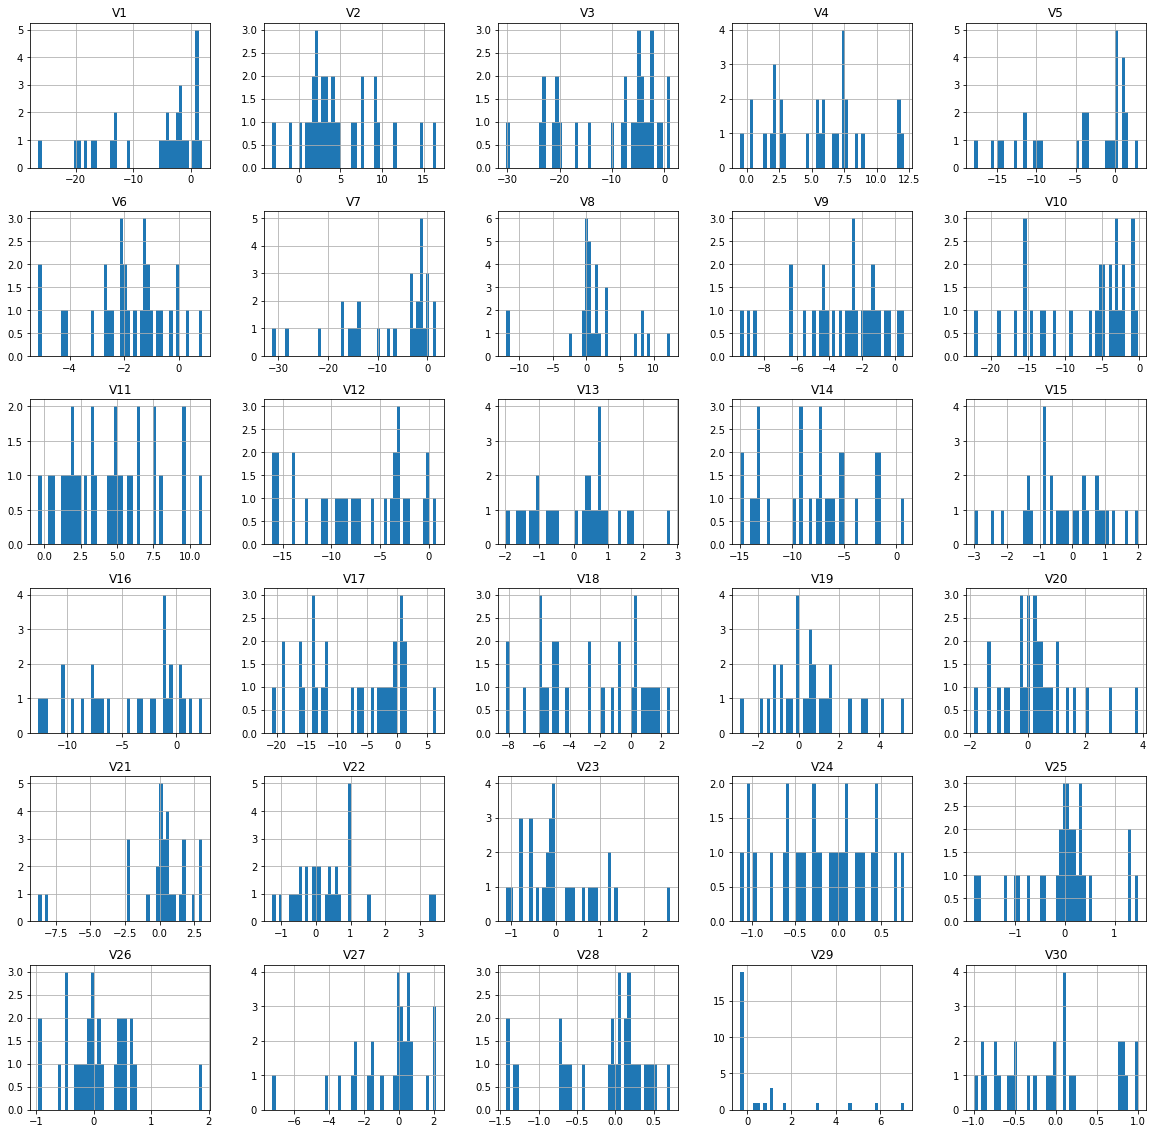

In [19]:
fraud_val_df.drop(columns=['ID','Class']).hist(bins = 50, figsize=(20,20))
plt.show()